In [1]:
import h5py    
import numpy as np  
import bluepysnap
import matplotlib.pyplot as plt
import bluepysnap
from bluepysnap import Simulation as snap_sim
from pathlib import Path

In [2]:
def read_result(result_path):
    read_result = h5py.File(result_path)
    result = read_result['report']['All']['data']

    return(result)

def mapping_extract(result_path):
    read_result = h5py.File(result_path)
    result = read_result['report']['All']['data']
        
    extract_mapping = read_result['report']['All']['mapping']['node_ids'][:]
    
    t0 = read_result['report']['All']['mapping']['time'][0]
    T =read_result['report']['All']['mapping']['time'][1]
    dt = read_result['report']['All']['mapping']['time'][2]

    
    N= (T-t0)/dt
    time_line = np.linspace(t0,T, int(N))
    N2 = (T-t0)/0.025
    voltage_time_line = np.linspace(t0,T,int(N2))
    return(extract_mapping, time_line, voltage_time_line)

In [4]:
# read the circuit from ../../config/circuit_config.json
# NOTE: in circuit_config.json many path are relative
# We need to read the circuit to get the info about the neurons as e-type and layer
#circuit = bluepysnap.Circuit('/gpfs/bbp.cscs.ch/data/project/proj137/farinaNGV/Paper_results/config/circuit_config.json')
circuit = bluepysnap.Circuit('../../config/circuit_config.json' )
node_population = circuit.nodes["All"]
pandas_nodes = node_population.get()
print('Nodes in the circuit', len(node_population.get().index.to_list()))

Nodes in the circuit 129348


In [4]:
# Path: Results Folder (where reporting_metabolism_young is) can be downloaded from 10.5281/zenodo.14187063
# Path where the simulation results are stored
results_path ='/gpfs/bbp.cscs.ch/data/project/proj137/farinaNGV/Paper_results/my_simulation/'

In [5]:
sim_results_path = results_path + 'reporting_metabolism_young/'
voltage_met = read_result(sim_results_path + 'ndam_v.h5')
ATP_met = read_result(sim_results_path+  'ndam_atpi.h5')
after_ATP_met = read_result(sim_results_path+ 'metab_atpi_after_sync.h5')
before_ATP_met = read_result(sim_results_path+ 'metab_atpi_before_sync.h5')
mapping_met,time_line_met, volt_time_met = mapping_extract(sim_results_path+ 'ndam_nai.h5')
time_met_after = np.arange(0,3100, 100)

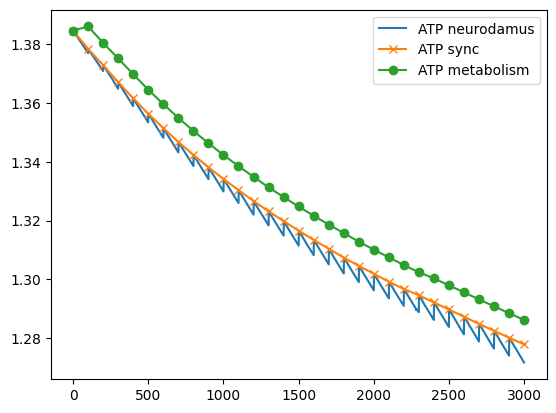

In [6]:
# Plot ATP for one neuron to visalize
idx = 3
plt.plot(time_line_met[:], ATP_met[:,idx], '-', label='ATP neurodamus')
plt.plot(time_met_after , after_ATP_met[:,idx], '-x', label='ATP sync')
plt.plot(time_met_after , before_ATP_met[:,idx], '-o',label='ATP metabolism')
plt.legend()

In [7]:
# Find indices of local minima
from scipy.signal import argrelextrema

In [8]:
def y_befor(idx):
    y_I = after_ATP_met[:-2,idx]
    return(y_I)

In [9]:
def y_met(idx):
    y_M = before_ATP_met[1:-1,idx]
    return(y_M)

In [10]:
def y_ndam(idx):
    data  = ATP_met[:,idx]
    #local_minima_indices = argrelextrema(data, np.less)[0]
    local_minima_indices = argrelextrema(ATP_met[:,0], np.less)[0]
    y_N = data[local_minima_indices]
    return(y_N)

In [11]:
def y_produced(idx):
    y_produced = np.abs(y_met(idx)-y_befor(idx))
    return(y_produced)
def final_y_produced(idx):
    y_produced = np.abs(before_ATP_met[-1,idx]-after_ATP_met[-2,idx])
    return(y_produced)

In [12]:
def y_consumed(idx):
    y_consumed= np.abs(y_ndam(idx)-y_befor(idx))
    return(y_consumed)

def final_y_consumed(idx):
    y_consumed= np.abs(ATP_met[-1,idx]-after_ATP_met[-2,idx])
    return(y_consumed)

In [13]:
# Importing Pandas to create DataFrame
import pandas as pd
 
# Creating Empty DataFrame and Storing it in variable df
df = pd.DataFrame()
df['ids'] = mapping_met
df['etype'] = [pandas_nodes['etype'][i] for i in df['ids']]
df['layer'] = [pandas_nodes['layer'][i] for i in df['ids']]
df['synapse_class'] = [ pandas_nodes['synapse_class'][i] for i in df['ids']]
df['x'] = [pandas_nodes['x'][i] for i in df['ids']]
df['y'] = [pandas_nodes['y'][i] for i in df['ids']]
df['z'] = [pandas_nodes['z'][i] for i in df['ids']]

In [14]:
df['mean_ATP_consumed'] = [y_produced(i).mean() for i in range(len(df['ids']))]

In [24]:
df['mean_ATP_produced'] = [y_consumed(i).mean() for i in range(len(df['ids']))]

In [17]:
df['fin_ATP_consumed'] = [final_y_produced(i) for i in range(len(df['ids']))]
df['fin_ATP_produced'] = [final_y_consumed(i) for i in range(len(df['ids']))]

In [22]:
#add the spikes count per metabolism simulation
df['spikes_met'] = pd.read_csv('./Data/spikes_ndam_met_aged.csv')['spikes_met']

In [31]:
## Save the DataFrame to a CSV file
#df.to_csv('./Data/Fig3A_ATP_concentration_production_consumption_newdate.csv', index=False) #Used for both Fig2D & Fig 3A